# Livingston (KLVM, MTELV, MTLWM) ProbGust Reliablity

Calculate the reliability of ProbGust, and previous guidance.

## Import modules

In [1]:
import xarray            as xr
import pandas            as pd
import numpy             as np
import matplotlib.pyplot as plt
import matplotlib.dates  as mdates
import seaborn           as sns
import scipy.stats       as stats
import pint

## Set some contants

In [2]:
sns.set_theme(color_codes=True)
units = pint.UnitRegistry()
hour = pd.to_timedelta('1H')
normal_distribution = stats.norm()

## Define utility functions

### bias:
apply bias correction to dataframe

In [3]:
def bias(s):
    s.windGust = regression.slope[s.stn] * s.windGust + regression.intercept[s.stn]
    return s

### generate_probability
Calculate the Z-Score given the bias-corrected NBM mean wind gust and standard deviation

In [4]:
def generate_prob_gust(data, threshold, unit='mph', tollerance = 0.6, mean='10_meter_wind_speed_of_gust_mean', standard_deviation='10_meter_wind_speed_of_gust_standard_deviation'):
    threshold = pint.Quantity(threshold - tollerance, units(unit)).to(units('m s**-1')).magnitude
    z_score = pd.Series((threshold - data[mean]) / data[standard_deviation], index=data.index)
    return pd.Series(np.round((100 * normal_distribution.sf(z_score))), index=data.index)


In [5]:
def add_prob_gust(row):
    for threshold in thresholds[row.stn]:
        if row.windGustSpread > 0:
            row['ProbGust_{0:d}'.format(threshold)] = generate_prob_gust(row, threshold, mean='windGust', standard_deviation='windGustSpread')
        else:
            row['ProbGust_{0:d}'.format(threshold)] = 0
    return row

## Read Bias-Correction parameters

In [6]:
regression = pd.read_json('../data/derived/regressions.json', orient='table')
regression.index = [x if len(x) > 3 else 'K' + x for x in regression.index]
regression

,slope,intercept,rvalue,pvalue,stderr
MTELV,0.893859,6.923222,0.703279,1.471382e-186,0.025618
KLVM,1.022861,4.676071,0.796859,0.000000e+00,0.018798
MTLWM,0.894840,7.826072,0.683627,2.977567e-138,0.030286
K6S0,0.796994,8.129035,0.685876,3.758471e-201,0.022276
K1KM,0.715568,8.136230,0.735165,1.881445e-130,0.023934
UMHM,0.695138,9.328585,0.715288,1.233256e-229,0.017768


## Read NBM Data, Bias Correct, and Map Cities

In [66]:
cities = {'MTELV': 'Livingston', 'MTLWM': 'Livingston', 'KLVM': 'Livingston', 'UMHM': 'Harlowton', 'K1KM': 'Harlowton', 'K6S0': 'Big Timber'}
thresholds = {'Livingston': [50, 58, 75], 'Big Timber': [50, 58, 70], 'Harlowton': [50, 58, 70]}

nbm_data = pd.read_csv('../data/debug/NBMWindData.csv').apply(bias, axis=1)
nbm_data['city'] = nbm_data.stn.apply(lambda a:cities[a])
nbm_data.run = pd.to_datetime(nbm_data.run)
nbm_data.valid = pd.to_datetime(nbm_data.valid)
nbm_data

,stn,run,valid,windGust,windGustSpread,city
0,K1KM,2021-05-19 12:00:00,2021-05-19 13:00:00,13.860773,NaN,Harlowton
1,K1KM,2021-05-19 12:00:00,2021-05-19 14:00:00,11.213172,2.22,Harlowton
2,K1KM,2021-05-19 12:00:00,2021-05-19 15:00:00,13.646103,0.60,Harlowton
3,K1KM,2021-05-19 12:00:00,2021-05-19 16:00:00,16.651488,2.32,Harlowton
4,K1KM,2021-05-19 12:00:00,2021-05-19 17:00:00,12.214967,1.00,Harlowton
...,...,...,...,...,...,...
139285,UMHM,2021-09-11 12:00:00,2021-09-21 12:00:00,NaN,0.60,Harlowton
139286,UMHM,2021-09-11 12:00:00,2021-09-21 18:00:00,NaN,1.32,Harlowton
139287,UMHM,2021-09-11 12:00:00,2021-09-22 00:00:00,NaN,2.40,Harlowton
139288,UMHM,2021-09-11 12:00:00,2021-09-22 06:00:00,NaN,1.40,Harlowton


In [67]:
# nbm_back = nbm_data.copy(deep=True)
# nbm_data = nbm_back.copy(deep=True)
nbm_data['criteria'] = nbm_data.city
nbm_data = pd.concat([nbm_data.apply(lambda a: a.apply(lambda b:thresholds[b][i]) if a.name == 'criteria' else a) for i in range(3)])
nbm_data['criteria_ms'] = pint.Quantity(nbm_data.criteria.to_numpy() - 0.6, units('MPH')).to(units('m s**-1')).magnitude
nbm_data['z'] = (nbm_data.criteria_ms - nbm_data.windGust) / nbm_data.windGustSpread
nbm_data['ProbGust'] = np.round((1-normal_distribution.cdf(nbm_data.z)) * 100)
nbm_data.windGust = pint.Quantity(nbm_data.windGust.to_numpy(), units('m s**-1')).to(units('MPH')).magnitude
nbm_data.windGustSpread = pint.Quantity(nbm_data.windGustSpread.to_numpy(), units('m s**-1')).to(units('MPH')).magnitude
nbm_data = nbm_data.groupby(['city', 'run', 'valid', 'criteria']).max()[['ProbGust']].fillna(value=0).reset_index().pivot(index=['city', 'run', 'valid'], columns='criteria', values='ProbGust')
nbm_data

criteria                                             50   58   70   75
city       run                 valid                                  
Big Timber 2021-05-19 12:00:00 2021-05-19 13:00:00  0.0  0.0  0.0  NaN
                               2021-05-19 14:00:00  0.0  0.0  0.0  NaN
                               2021-05-19 15:00:00  0.0  0.0  0.0  NaN
                               2021-05-19 16:00:00  1.0  0.0  0.0  NaN
                               2021-05-19 17:00:00  0.0  0.0  0.0  NaN
...                                                 ...  ...  ...  ...
Livingston 2021-09-11 12:00:00 2021-09-21 12:00:00  0.0  0.0  NaN  0.0
                               2021-09-21 18:00:00  0.0  0.0  NaN  0.0
                               2021-09-22 00:00:00  0.0  0.0  NaN  0.0
                               2021-09-22 06:00:00  0.0  0.0  NaN  0.0
                               2021-09-22 12:00:00  0.0  0.0  NaN  0.0

[69645 rows x 4 columns]

# siteID = 'Livingston'
# nbm = nbm_data[nbm_data.stn == siteID].reset_index(drop=True)

# for threshold in [50, 58, 75]:
#     nbm['ProbGust_{0:d}'.format(threshold)] = generate_prob_gust(nbm, threshold, mean='windGust', standard_deviation='windGustSpread')
# nbm
nbm = nbm_data.apply(add_prob_gust, axis=1)
nbm

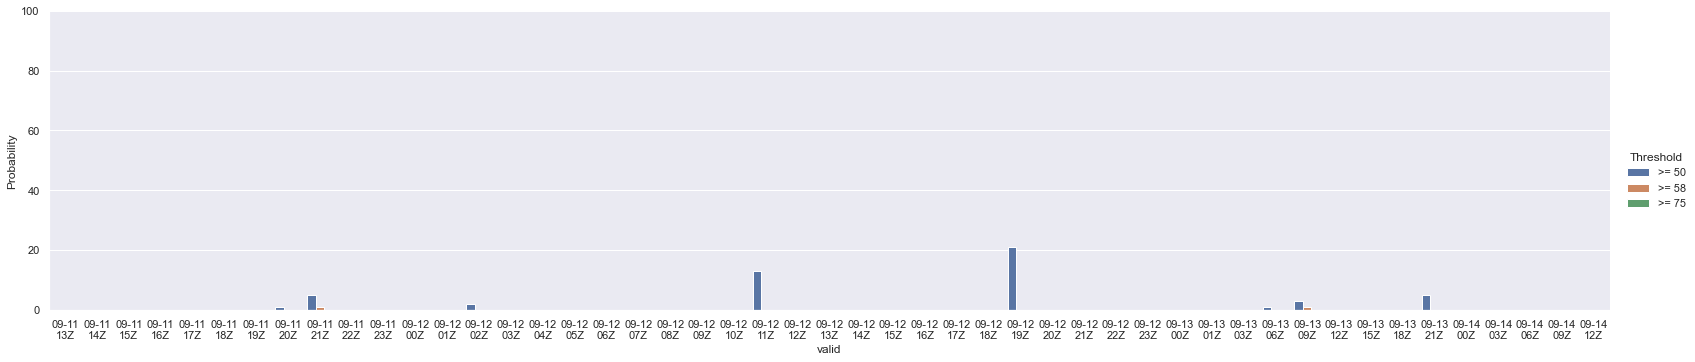

In [95]:
station = 'Livingston'
start = pd.to_datetime('2021-09-11T12:00:00Z')
end = start + pd.to_timedelta('3D')
run = nbm_data[(nbm_data.index.get_level_values(0) == station) & (nbm_data.index.get_level_values(1) == start.to_datetime64()) & (nbm_data.index.get_level_values(2) <= end.to_datetime64())].reset_index().set_index('valid')
run = run[[x[0] for x in run.max().items() if type(x[1]) == np.float64 and np.isfinite(x[1])]]

run.to_csv('output/run.csv')
run.columns = ['>= {0:d}'.format(x) for x in run.columns]

run = run.reset_index().melt(id_vars='valid', value_name="Probability", var_name="Threshold")

run.valid = [x.strftime('%m-%d\n%HZ') if x.hour % 1 == 0 else x.strftime('%HZ') for x in run.valid] #run.valid.dt.strftime('%m-%d\n%HZ')
g = sns.catplot(data=run, x='valid', y='Probability', hue='Threshold', kind='bar', aspect=4.5, facet_kws=dict(ylim=(0,100)))
# g = sns.relplot(data=run, x='valid', y='Probability', hue='Threshold', kind='line', aspect=4.5, facet_kws=dict(ylim=(0,100)))
